Imports

In [1]:
#############
###paths#####
#############
import sys
import os

from importlib_metadata import distribution
pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
modellingephemeral = '/rds/general/ephemeral/user/mo2016/ephemeral/Documents/modelling'

sys.path.append(modellingpath + '/lib')
#############

from numerical.cn_plot import plot1D, surfpattern
from numerical.countPeaksAnalysisFunctions import countPeaks, varPeakDistFunction
from numerical.generalFunctions import round_it
from numerical.fourierAnalysisFunctions import psEntropyFunction, plotFourier


from analytical.linear_stability_analysis import detailed_turing_analysis_dict
from randomfunctions import plot_all_dispersion, plot_highest_dispersion

from scipy.signal import find_peaks
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



System definitions

In [2]:
circuit_n='turinghill'
variant= 0
n_species=2
mechanism='nogrowth'
L=50; dx =1; J = int(L/dx)
T =500; dt = 0.005; N = int(T/dt)
boundaryCoeff=2;rate=0.1

filename= lambda mechanism, parID: 'circuit%s_variant%s_bc%s_%s_rate%s_ID%s_L%r_J%r_T%r_N%r'%(circuit_n,variant,boundaryCoeff, mechanism,rate,parID,L,J,T,N)
n_param_sets=2000000
lsa_df= pickle.load( open(modellingpath + '/growth/out/analytical/lsa_dataframes/lsa_df_%s_variant%r_%rparametersets.pkl'%(circuit_n,variant,n_param_sets), "rb"))
# single_lsa_df =  lsa_df.xs(0, level=1)
# parID_list = pickle.load(open( modellingpath + '/growth/out/numerical/%s/%s/data/parID_list_%s.pkl'%(circuit_n,mechanism,filename('x')), "rb" ) )
# parID_list = [int(parID) for parID in parID_list]
# instability_df= pickle.load( open(modellingpath + '/growth/out/analytical/instability/instability_df_%s_variant%r_%rparametersets.pkl'%(circuit_n,variant,n_param_sets), "rb"))
# singleSsInstability_df = instability_df.loc[instability_df['ss_n']==1]
# singleSsInstability_df
pattern_df = pickle.load(open( modellingpath + '/growth/out/patternAnalysis/%s/%s/pattern/pattern_df_%s.pkl'%(circuit_n,mechanism,filename(mechanism,'x')), 'rb'))


Functions

In [3]:
def parID_display(parIDss, L,J,T,round=False,crop=100,ss_n=0,df = pattern_df):
    #data
    U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/simulation/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))
    plot1D(U_final,round=round)

    plt.subplots(figsize=(10,4))

    #dispersion
    plt.subplot(121)
    parID_dispersion(parIDss,crop)
    #convergence
    plt.subplot(122)

    parID_surfpattern(parIDss,L,J,T)
    plt.tight_layout()
    plt.show()
def parID_surfpattern(parIDss,L,J,T,record_every_x_hours = 10):
    #data 
    U_record = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))    
    #grids
    dx = float(L)/float(J-1)
    x_grid = np.array([j*dx for j in range(J)])
    reduced_t_grid = np.arange(0,T,record_every_x_hours) 

    #plot
    surfpattern(U_record, [x_grid, reduced_t_grid], 'linear',  morphogen=1, rate=0, savefig=False,filename='',logResults=False,normalize=False)


def parID_dispersion(parIDss,crop, df = pattern_df):
    #dispersion
    parID,ss = [int(x) for x in parIDss.split('.')]

    par_dict = df.loc[(parID,ss)].to_dict() #converts a dataframe row into a dictionary outputing a dictionary for a specific parameter set
    out = detailed_turing_analysis_dict(par_dict, circuit_n, n_species)
    plot_highest_dispersion(out[-3][ss-1],crop=crop)


Value counts and df definitions

In [4]:
print('\n',pattern_df['system_class'].value_counts())
print('\n',pattern_df['pattern'].value_counts())



 simple stable           2338152
simple unstable          166960
complex unstable          95381
hopf                      61890
turing I hopf              1047
turing I oscillatory         29
no steady state              10
turing I                      2
Name: system_class, dtype: int64

 Homogeneous                     79933
Non-Stationary heterogeneity    49178
Temporal Oscillator             43339
Stationary spatial wave          5726
Name: pattern, dtype: int64


In [9]:
pattern_df.loc[1482]

,ba,bb,Va,Vb,kaa,kba,kab,kbb,mua,mub,d_B,d_A,n,ss_n,ss_list,ss_class,system_class,maxeig,complex_dispersion,pattern
0,0.01,0.01,11.59167,29.264505,0.245661,0.201507,0.445943,132.168508,12.565971,19.345495,0.121964,1.0,2.0,3.0,"[0.0008057215913616723, 0.0005218537668570272]",stable point,simple stable,-12.256460+0.000000j,False,Homogeneous
1,0.01,0.01,11.59167,29.264505,0.245661,0.201507,0.445943,132.168508,12.565971,19.345495,0.121964,1.0,2.0,3.0,"[0.15901736026926516, 0.17116751164067429]",stable spiral,simple stable,-7.144555+14.484990j,True,Homogeneous
2,0.01,0.01,11.59167,29.264505,0.245661,0.201507,0.445943,132.168508,12.565971,19.345495,0.121964,1.0,2.0,3.0,"[0.07328995812593224, 0.040301590825694955]",unstable point,complex unstable,9.007178+0.000000j,True,Stationary spatial wave


## Stationary spatial wave

In [6]:
df1 = pattern_df.loc[(pattern_df['pattern']=='Stationary spatial wave') ]
print(df1['system_class'].value_counts())


simple stable           5382
simple unstable          114
hopf                     104
complex unstable          83
turing I hopf             39
turing I oscillatory       3
turing I                   1
Name: system_class, dtype: int64


In [ ]:
for parIDindex in df1.index[:100]:
    
    
    par_dict = df1.loc[parIDindex].to_dict() #converts a dataframe row into a dictionary outputing a dictionary for a specific parameter set
    print(par_dict['system_class'])
    print(par_dict['ss_n'])    
    # print(par_dict['pattern'])

    # print(par_dict['d_A'],par_dict['d_B'])

    # #load records 
    parIDss = f'{parIDindex[0]}.{parIDindex[1]}'
    print(parIDss)
    U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/simulation/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))
    U_record = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))    

    # U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/simulation/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))
    # U_record = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))



    parID_display(parIDss,L,J,T, crop=100)

    #check if flat with diff function
    diffUfinal = np.round(np.diff(U_final),decimals=3)
    if np.all(diffUfinal==0)==True:
        flat=True
    else:
        flat=False

    #check if convergence with diff function
    diffUrecord = np.round(np.diff(U_record[1][-10:], axis=0),decimals=6)
    
    if np.all(diffUrecord==0) ==True:
        converged=True
    else:
        converged=False


    if flat==True and converged==True:
        pattern='Homogeneous'
    if flat==True and converged==False:
        pattern='Temporal Oscillator'
    if flat==False and converged==True:
        # pattern = 'Stationary periodic wave'
        pattern = 'Stationary spatial wave'
    if flat==False and converged==False:
        pattern = 'Non-Stationary heterogeneity'

simple stable
1.0
25.0


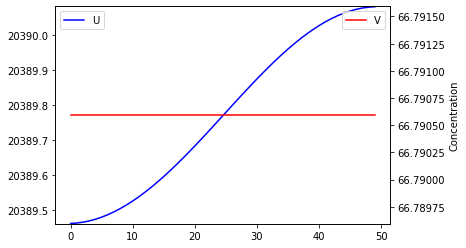

<ipython-input-3-274884f1c816>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


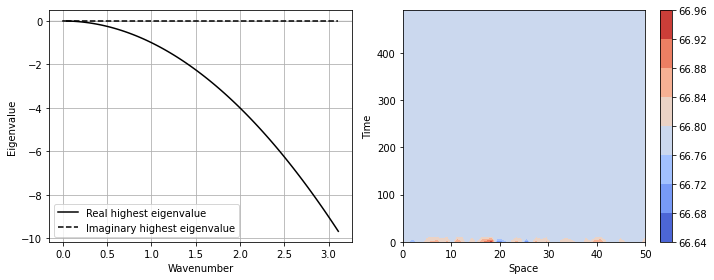

[[1.20929912e-03 2.41402323e-03 3.60961416e-03 4.79154263e-03
  5.95532382e-03 7.09653248e-03 8.21081804e-03 9.29391912e-03
  1.03416773e-02 1.13500541e-02 1.23151432e-02 1.32331855e-02
  1.41005826e-02 1.49139116e-02 1.56699378e-02 1.63656274e-02
  1.69981624e-02 1.75649509e-02 1.80636392e-02 1.84921233e-02
  1.88485588e-02 1.91313705e-02 1.93392633e-02 1.94712274e-02
  1.95265468e-02 1.95048046e-02 1.94058873e-02 1.92299908e-02
  1.89776200e-02 1.86495906e-02 1.82470294e-02 1.77713718e-02
  1.72243586e-02 1.66080308e-02 1.59247256e-02 1.51770663e-02
  1.43679541e-02 1.35005571e-02 1.25782984e-02 1.16048426e-02
  1.05840809e-02 9.52011498e-03 8.41723957e-03 7.27992390e-03
  6.11279284e-03 4.92060606e-03 3.70823631e-03 2.48064812e-03
  1.24287622e-03]
 [6.25277607e-13 1.22213351e-12 2.18847163e-12 2.07478479e-12
  3.02691205e-12 4.46220838e-12 4.74642547e-12 4.74642547e-12
  5.41433565e-12 5.13011855e-12 6.08224582e-12 6.30961949e-12
  7.38964445e-12 7.58859642e-12 7.58859642e-12 8.029

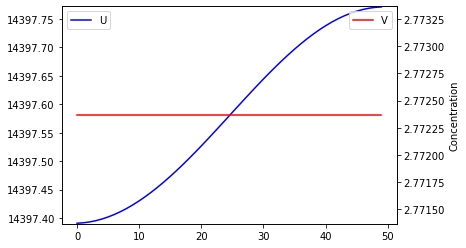

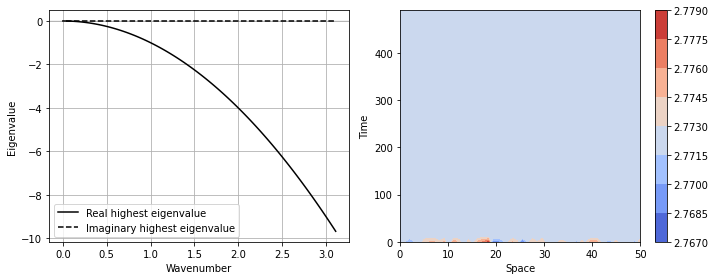

[[7.40050808e-04 1.47730214e-03 2.20896440e-03 2.93226576e-03
  3.64446174e-03 4.34284434e-03 5.02475123e-03 5.68757427e-03
  6.32876928e-03 6.94586447e-03 7.53646935e-03 8.09828344e-03
  8.62910481e-03 9.12683847e-03 9.58950477e-03 1.00152478e-02
  1.04023426e-02 1.07492030e-02 1.10543881e-02 1.13166106e-02
  1.15347419e-02 1.17078182e-02 1.18350466e-02 1.19158086e-02
  1.19496664e-02 1.19363649e-02 1.18758348e-02 1.17681956e-02
  1.16137558e-02 1.14130150e-02 1.11666627e-02 1.08755770e-02
  1.05408235e-02 1.01636516e-02 9.74549060e-03 9.28794634e-03
  8.79279423e-03 8.26197299e-03 7.69757752e-03 7.10185042e-03
  6.47717302e-03 5.82605541e-03 5.15112611e-03 4.45512009e-03
  3.74086721e-03 3.01128075e-03 2.26934274e-03 1.51809126e-03
  7.60607498e-04]
 [6.11066753e-13 1.21458399e-12 1.83097981e-12 2.43227660e-12
  3.02247116e-12 3.60111940e-12 4.16688906e-12 4.71489514e-12
  5.24602584e-12 5.75450798e-12 6.24877927e-12 6.71596112e-12
  7.15694171e-12 7.56772423e-12 7.94697641e-12 8.303

In [12]:
for parIDindex in df1.index[:2]:
    
    
    par_dict = df1.loc[parIDindex].to_dict() #converts a dataframe row into a dictionary outputing a dictionary for a specific parameter set
    print(par_dict['system_class'])
    print(par_dict['ss_n'])    
    # print(par_dict['pattern'])

    # print(par_dict['d_A'],par_dict['d_B'])

    # #load records 
    parIDss = f'{parIDindex[0]}.{parIDindex[1]}'
    print(parIDss)
    U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/simulation/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))
    U_record = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))    

    # U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/simulation/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))
    # U_record = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))



    parID_display(parIDss,L,J,T, crop=100)
    print(np.round(np.diff(U_final),decimals=3))
    #check if flat with diff function
    diffUfinal = np.round(np.diff(U_final),decimals=3)
    if np.all(diffUfinal==0)==True:
        flat=True
    else:
        flat=False

    #check if convergence with diff function
    diffUrecord = np.round(np.diff(U_record[1][-10:], axis=0),decimals=6)
    
    if np.all(diffUrecord==0) ==True:
        converged=True
    else:
        converged=False


    if flat==True and converged==True:
        pattern='Homogeneous'
    if flat==True and converged==False:
        pattern='Temporal Oscillator'
    if flat==False and converged==True:
        # pattern = 'Stationary periodic wave'
        pattern = 'Stationary spatial wave'
    if flat==False and converged==False:
        pattern = 'Non-Stationary heterogeneity'

print(pattern, f'Converged{converged}', f'flat{flat}')

## Turing I Hopf

In [ ]:
df1 = pattern_df.loc[(pattern_df['system_class']=='turing I hopf') &  (pattern_df['pattern']=='Non-Stationary heterogeneity')]
print(pattern_df.loc[pattern_df['system_class']=='turing I hopf']['pattern'].value_counts())


In [ ]:
for parID in df1.index:
    if pattern_df.loc[parID]['ss_n']==1:
        print(parID)
        # print(pattern_df.loc[parID])
        # print(pattern_df.loc[parID]['ss_n'])
        #load records 
        U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
        U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))


        parID_display(parID,L,J,T, crop=100)

        #check if flat with diff function
        diffUfinal = np.round(np.diff(U_final),decimals=3)
        if np.all(diffUfinal==0)==True:
            flat=True
        else:
            flat=False

        #check if convergence with diff function
        diffUrecord = np.round(np.diff(U_record[1][-10:], axis=0),decimals=6)
        
        if np.all(diffUrecord==0) ==True:
            converged=True
        else:
            converged=False
        time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
        # autocorr(np.array(time_vector))
        print(f'flat: {flat}, converged: {converged}')
        print('\n')


## Hopf 

In [ ]:
df1 = pattern_df.loc[(pattern_df['system_class']=='hopf') &  (pattern_df['pattern']=='Non-Stationary heterogeneity')]
print(pattern_df.loc[pattern_df['system_class']=='hopf']['pattern'].value_counts())


In [ ]:
for parID in df1.index[:30]:
    if pattern_df.loc[parID]['ss_n']==1:
        print(parID)
        # print(pattern_df.loc[parID])
        # print(pattern_df.loc[parID]['ss_n'])
        #load records 
        U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
        U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))


        parID_display(parID,L,J,T, crop=400)

        #check if flat with diff function
        diffUfinal = np.round(np.diff(U_final),decimals=3)
        if np.all(diffUfinal==0)==True:
            flat=True
        else:
            flat=False

        #check if convergence with diff function
        diffUrecord = np.round(np.diff(U_record[1][-10:], axis=0),decimals=6)
        
        if np.all(diffUrecord==0) ==True:
            converged=True
        else:
            converged=False
        time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
        # autocorr(np.array(time_vector))
        print(f'flat: {flat}, converged: {converged}')
        print('\n')


In [ ]:

for parID in parID_list[20:30]:
    print(parID)
    #load records 
    U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
    U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))


    # parID_display(parID,L,J,T, crop=100)

    #check if flat with diff function
    diffUfinal = np.round(np.diff(U_final),decimals=3)
    if np.all(diffUfinal==0)==True:
        flat=True
    else:
        flat=False

    #check if convergence with diff function
    diffUrecord = np.round(np.diff(U_record[1][-10:], axis=0),decimals=3)
    if np.all(diffUrecord==0) ==True:
        converged=True
    else:
        converged=False


In [ ]:
parID_display(8648,L,J,T, crop=3)

In [ ]:
def autocorr(x):
    n = x.size
    norm = (x - np.mean(x))
    result = np.correlate(norm, norm, mode='same')
    acorr = result[n//2 + 1:] / (x.var() * np.arange(n-1, n//2, -1))
    lag = np.abs(acorr).argmax() + 1
    r = acorr[lag-1]        
    if np.abs(r) > 0.5:
      print('Appears to be autocorrelated with r = {}, lag = {}'. format(r, lag))
    else: 
      print('Appears to be not autocorrelated')
    return r, lag

In [ ]:
parID=2932
U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
autocorr(np.array(time_vector))
parID_display(parID,L,J,T, crop=20)


In [ ]:
parID=2886
U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
autocorr(np.array(time_vector))
parID_display(parID,L,J,T, crop=20)


In [ ]:
parID=193560
U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
autocorr(np.array(time_vector))
parID_display(parID,L,J,T, crop=20)


In [ ]:
parID=12019
print(parID)
print(pattern_df.loc[parID]['ss_n'])
#load records 
U_final = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))


parID_display(parID,L,J,T, crop=100)

#check if flat with diff function
diffUfinal = np.round(np.diff(U_final),decimals=3)
if np.all(diffUfinal==0)==True:
    flat=True
else:
    flat=False

#check if convergence with diff function
diffUrecord = np.round(np.diff(U_record[1][-50:], axis=0),decimals=6)
print(diffUrecord)
if np.all(diffUrecord==0) ==True:
    converged=True
else:
    converged=False
time_vector = [U_record[0][x][10] for x in range(len(U_record[0]))]
plt.plot(time_vector)
autocorr(np.array(time_vector))
print(f'flat: {flat}, converged: {converged}')
print('\n')